## What do bulk properties look like? 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-20 21:59:16.368928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 21:59:16.382542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 21:59:16.386666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%%time
DT = datasets.SimulationData(simulation_names = ['DG','P2L'], 
                             filter_scales    = ['50','100','200','400'], 
                             window_size      = 1, 
                             time_sel         = slice(0, 3600),
                             single_layer_mask_flag=True)

CPU times: user 1min 45s, sys: 20.8 s, total: 2min 5s
Wall time: 2min 41s


In [20]:
ds_P2L = DT.simulation_data['P2L']['100']
ds_DG = DT.simulation_data['DG']['100']

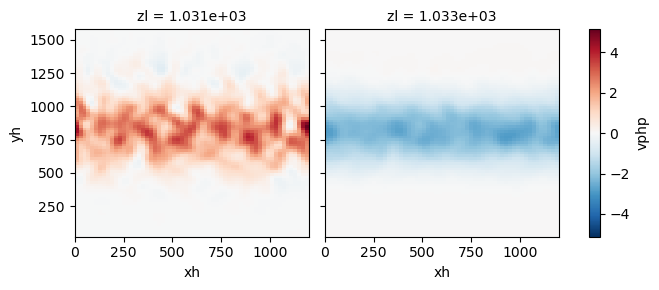

In [21]:
ds_P2L.vphp.isel(Time=slice(-400,None)).mean('Time').plot(col='zl')

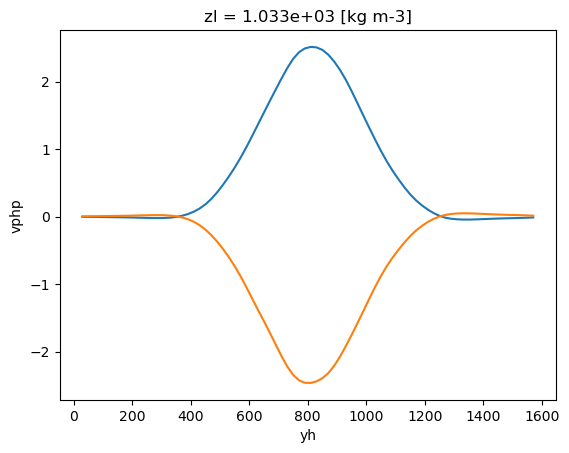

In [22]:
ds_P2L.vphp.isel(Time=slice(-400,None)).mean(['Time','xh']).isel(zl=0).plot()
ds_P2L.vphp.isel(Time=slice(-400,None)).mean(['Time','xh']).isel(zl=1).plot()

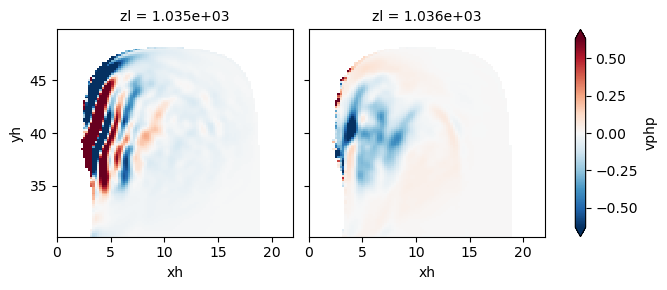

In [34]:
ds_DG.vphp.isel(Time=slice(-1000,None)).mean('Time').plot(col='zl', robust=True)

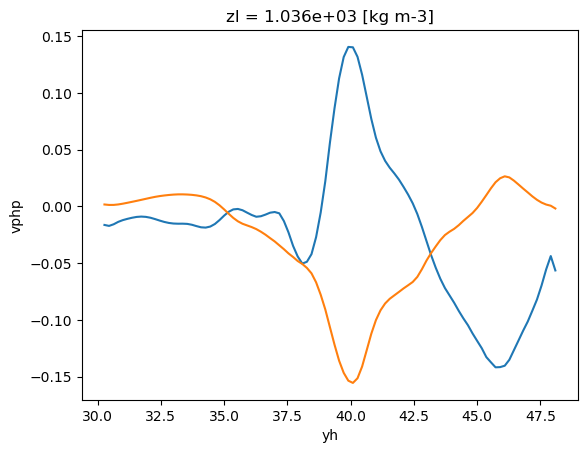

In [26]:
ds_DG.vphp.isel(Time=slice(-1000,None)).mean(['Time','xh']).isel(zl=0).plot()
ds_DG.vphp.isel(Time=slice(-1000,None)).mean(['Time','xh']).isel(zl=1).plot()

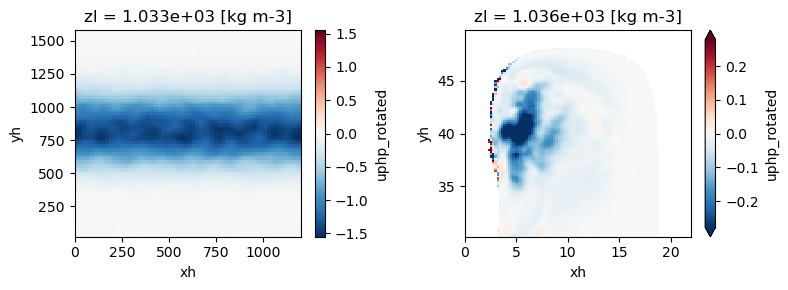

In [33]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_P2L.uphp_rotated.isel(Time=slice(-1000,None), zl=1).mean('Time').plot()

plt.subplot(122)
ds_DG.uphp_rotated.isel(Time=slice(-1000,None), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

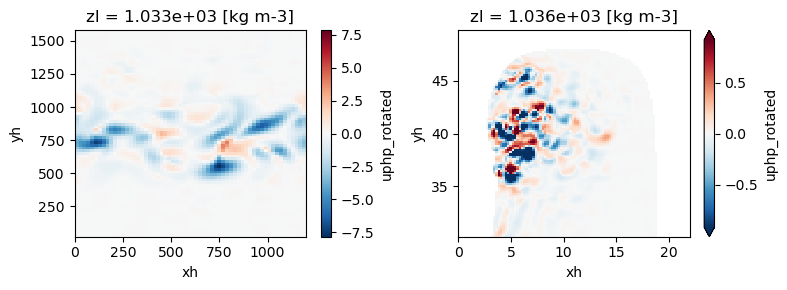

In [35]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_P2L.uphp_rotated.isel(Time=slice(-1,None), zl=1).mean('Time').plot()

plt.subplot(122)
ds_DG.uphp_rotated.isel(Time=slice(-1,None), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

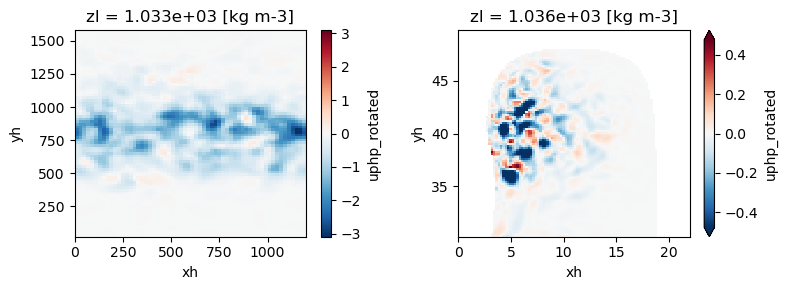

In [36]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_P2L.uphp_rotated.isel(Time=slice(-10,None), zl=1).mean('Time').plot()

plt.subplot(122)
ds_DG.uphp_rotated.isel(Time=slice(-10,None), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

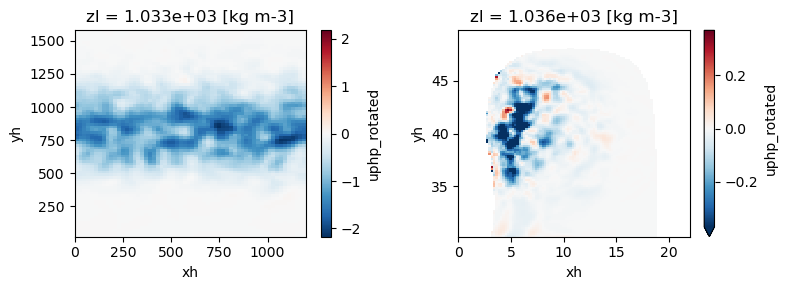

In [37]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_P2L.uphp_rotated.isel(Time=slice(-50,None), zl=1).mean('Time').plot()

plt.subplot(122)
ds_DG.uphp_rotated.isel(Time=slice(-50,None), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

In [39]:
ds_P2L.uphp_rotated.coarsen(Time=10)

DataArrayCoarsen [windows->{'Time': 10},side->left]

In [44]:
TS = ds_P2L.uphp_rotated.isel(zl=1).sel(xh=500, yh=800, method='nearest')

In [46]:
TS.load()

<xarray.DataArray 'uphp_rotated' (Time: 3600)> Size: 29kB
array([ 2.64586703e-04, -1.26606778e-03,  2.71231004e-03, ...,
       -3.39854503e+00, -2.60635933e+00,  1.48906190e+00])
Coordinates:
  * Time     (Time) object 29kB 0001-01-11 00:00:00 ... 0099-07-26 00:00:00
    xh       float64 8B 510.0
    yh       float64 8B 810.0
    zl       float64 8B 1.033e+03

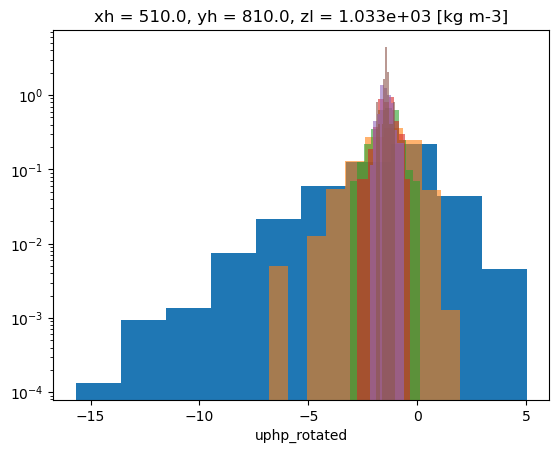

In [55]:
TS.plot.hist(density=True)
TS.coarsen(Time=4, boundary="trim").mean().plot.hist(density=True, alpha=0.6)
TS.coarsen(Time=16, boundary="trim").mean().plot.hist(density=True, alpha=0.6)
TS.coarsen(Time=32, boundary="trim").mean().plot.hist(density=True, alpha=0.6)
TS.coarsen(Time=64, boundary="trim").mean().plot.hist(density=True, alpha=0.6)
TS.coarsen(Time=128, boundary="trim").mean().plot.hist(density=True, alpha=0.6)

plt.yscale('log')

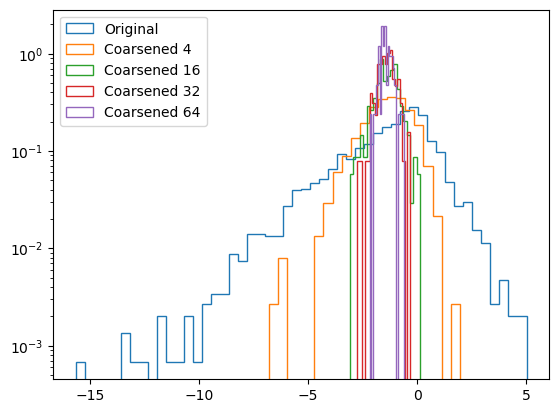

In [58]:
import matplotlib.pyplot as plt

# Plot the original histogram
plt.hist(TS, bins=50, density=True, histtype="step", label="Original")

# Define coarsening scales
coarsening_scales = [4, 16, 32, 64]

# Plot coarsened histograms
for scale in coarsening_scales:
    coarsened_TS = TS.coarsen(Time=scale, boundary="trim").mean()
    plt.hist(coarsened_TS, bins=21, density=True, histtype="step", label=f"Coarsened {scale}")

plt.yscale("log")
plt.legend()
plt.show()
